In [8]:
# VGG 19

In [9]:
import os
import random
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')

#For data manipulation
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image, ImageEnhance

#For neural network
import tensorflow
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator

In [10]:
#Load Training Data
train_data_dir = 'C:\\Users\\slpri\\OneDrive\\Desktop\\CAPSTONE PROJECT\\dataset\\Training'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

#Concatenate data paths
Fseries = pd.Series(filepaths, name = 'filepaths')
Lseries = pd.Series(labels, name = 'labels')

train_df = pd.concat([Fseries, Lseries], axis = 1)

In [11]:
#Load Testing Data
train_data_dir = 'C:\\Users\\slpri\\OneDrive\\Desktop\\CAPSTONE PROJECT\\dataset\\Testing'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

#Concatenate data paths
Fseries = pd.Series(filepaths, name = 'filepaths')
Lseries = pd.Series(labels, name ='labels')

ts_df = pd.concat([Fseries, Lseries], axis = 1)

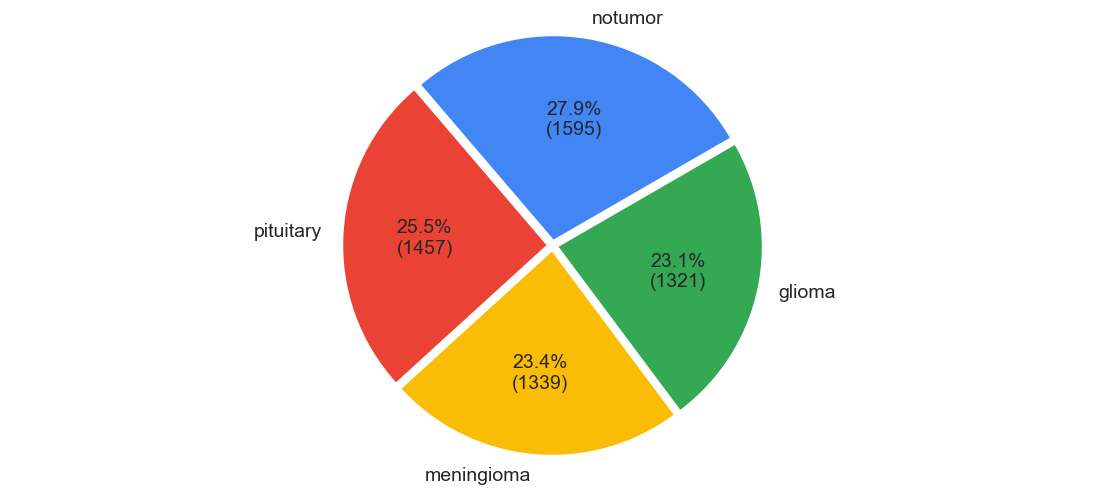

In [12]:
#Graph Dataset Split
plt.figure(figsize = (14, 6))
plt.rcParams.update({'font.size': 14})
data_balance = train_df.labels.value_counts()

def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct * total / 100.0))
    return "{:.1f}%\n({:d})".format(pct, val)

plt.pie(data_balance,
        labels = data_balance.index,
        autopct = custom_autopct,
        colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853'],
        explode = (0.025, 0.025, 0.025, 0.025),
        startangle = 30);
plt.axis('equal')
plt.show()

In [13]:
#Split dataset
valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 42)

In [14]:
#Augment and Preprocess Scans
batch_size = 32
img_size = (240, 240)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col = 'filepaths', y_col = 'labels', target_size = img_size, class_mode = 'categorical',
                                    color_mode = 'rgb', shuffle = True, batch_size = batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col = 'filepaths', y_col = 'labels', target_size = img_size, class_mode = 'categorical',
                                    color_mode = 'rgb', shuffle = True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col = 'filepaths', y_col = 'labels', target_size = img_size, class_mode = 'categorical',
                                    color_mode = 'rgb', shuffle = False, batch_size = batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


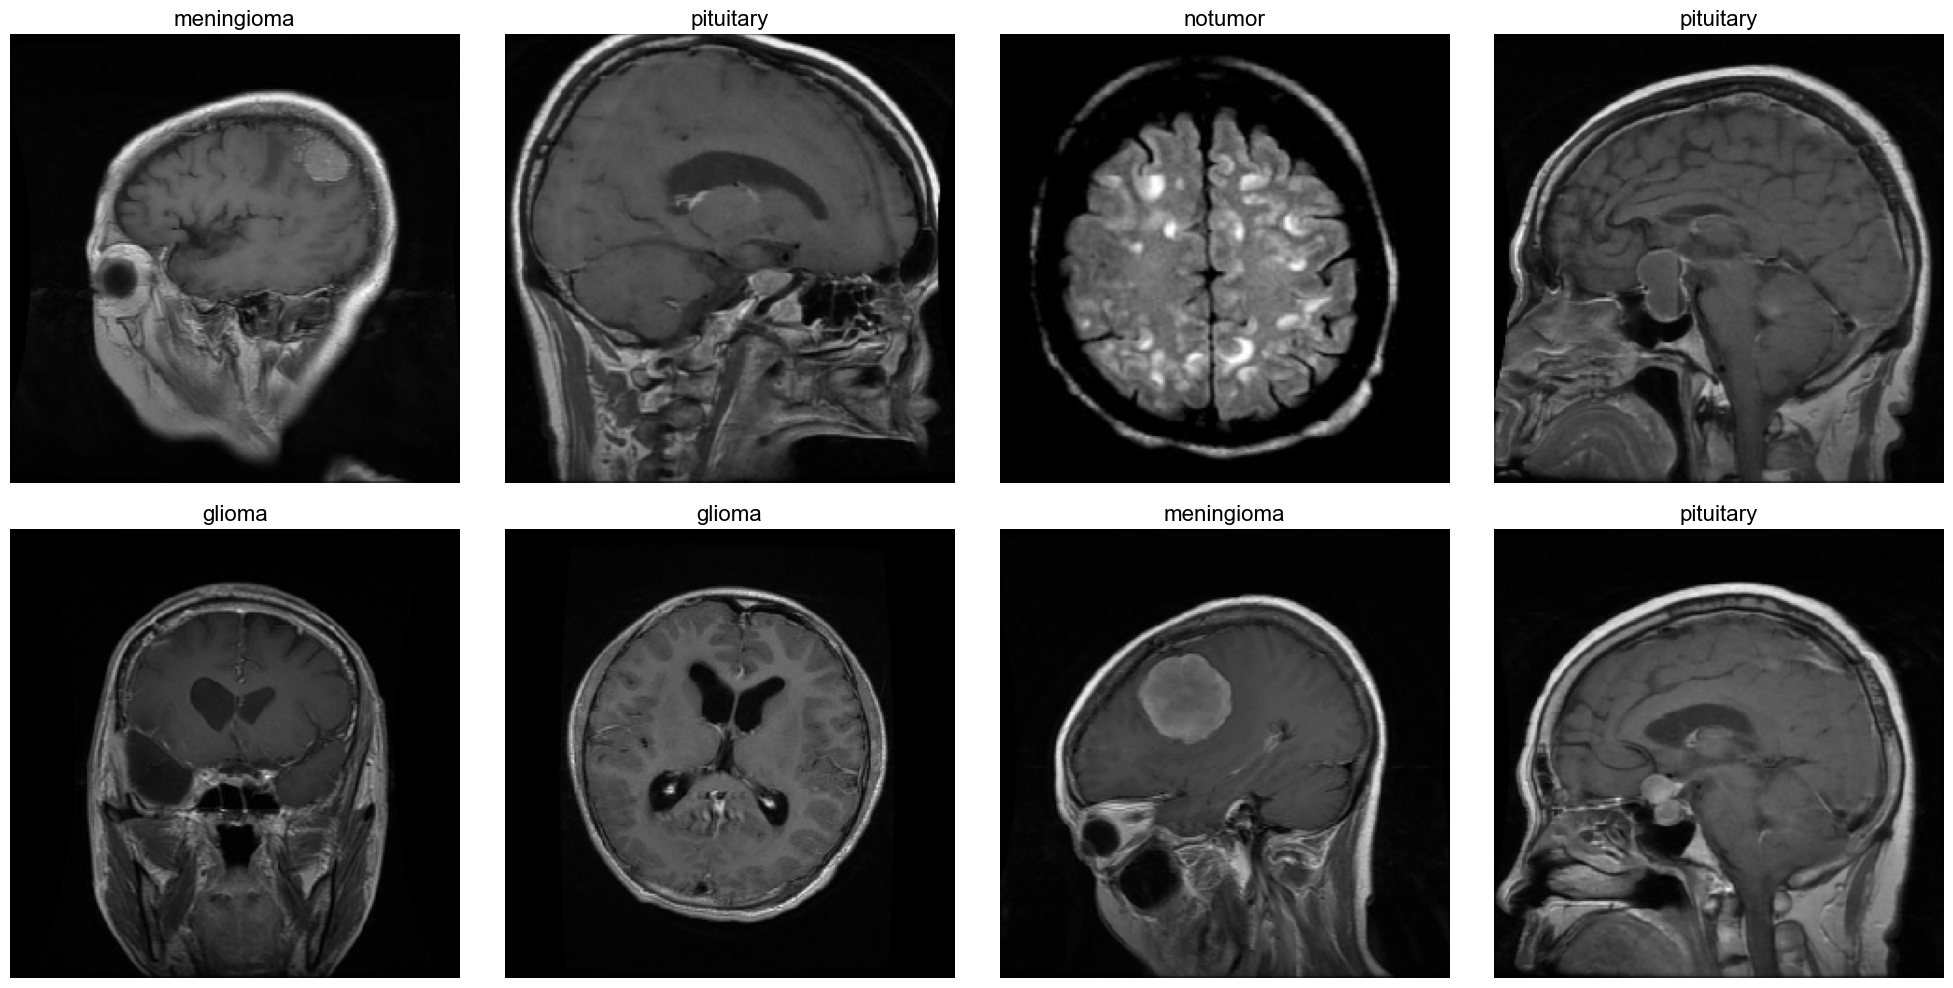

In [15]:
#Plot Processed Scans
g_dict = train_gen.class_indices     
classes = list(g_dict.keys())       
images, labels = next(train_gen)     

plt.figure(figsize = (20, 20))

for i in range(8):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255     
    plt.imshow(image)
    index = np.argmax(labels[i]) 
    class_name = classes[index]  
    plt.title(class_name, color = 'black', fontsize = 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

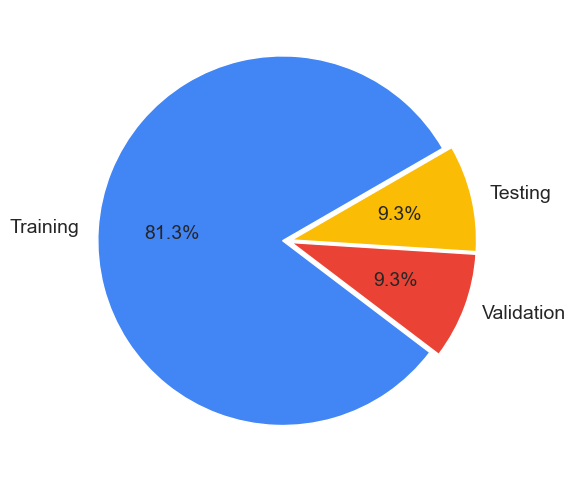

In [16]:
#Graph Dataset Directories
plt.figure(figsize = (14, 6))
plt.rcParams.update({'font.size': 14})

plt.pie([len(train_df), len(valid_df), len(test_df)],
        labels = ['Training','Validation', 'Testing'],
        colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853'], 
        autopct = '%.1f%%', 
        explode = (0.025, 0.025, 0.025),
        startangle = 30);

In [17]:
#Create model architecture
img_size = 240
class_count = len(list(train_gen.class_indices.keys()))

base_model = VGG19(input_shape = (img_size, img_size, 3), include_top = False, weights = 'imagenet')
for layer in base_model.layers:
    layer.trainable = False
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()

model.add(Input(shape = (img_size, img_size, 3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(class_count, activation = 'softmax'))

In [18]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,236,292 (88.64 MB)

 Trainable params: 10,291,332 (39.26 MB)

 Non-trainable params: 12,944,960 (49.38 MB)

In [ ]:
#LETS GO! NO ERRORS! Time to compile
model.compile(optimizer = Adam(learning_rate = 0.0001),
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

batch_size = 32
epochs = 20
history = model.fit(train_gen, 
                    epochs = epochs, 
                    verbose = 1, 
                    validation_data = valid_gen, 
                    shuffle = False)

Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 3893s 22s/step - accuracy: 0.6944 - loss: 1.7726 - val_accuracy: 0.8779 - val_loss: 0.3237
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 4211s 24s/step - accuracy: 0.8910 - loss: 0.3005 - val_accuracy: 0.9008 - val_loss: 0.2529
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 1838s 10s/step - accuracy: 0.9251 - loss: 0.2153 - val_accuracy: 0.9466 - val_loss: 0.1381
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 1286s 7s/step - accuracy: 0.9516 - loss: 0.1391 - val_accuracy: 0.9557 - val_loss: 0.1370
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 1578s 9s/step - accuracy: 0.9720 - loss: 0.0870 - val_accuracy: 0.9710 - val_loss: 0.1009
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 1268s 7s/step - accuracy: 0.9722 - loss: 0.0939 - val_accuracy: 0.9573 - val_loss: 0.1105
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 1247s 7s/step - accuracy: 0.9854 - loss: 0.0511 - val_accuracy: 0.9679 - val_loss: 0.0766
Epoch 8/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 1243s 7s/step - accuracy: 0.9879 - loss: 0.0419

In [ ]:
#Graph results
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'

plt.figure(figsize = (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, color = '#157AFF', label = 'Training loss')
plt.plot(Epochs, val_loss, color = '#FFBB33', label = 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s = 150, color = 'red', label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, color = '#157AFF', label = 'Training Accuracy')
plt.plot(Epochs, val_acc, color = '#FFBB33', label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s = 150, color = 'red', label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

NameError: name 'history' is not defined

In [ ]:
#Results for training, validating, testing
train_score = model.evaluate(train_gen, verbose = 1)
valid_score = model.evaluate(valid_gen, verbose = 1)
test_score = model.evaluate(test_gen, verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

In [ ]:
preds = model.predict(test_gen)  
y_pred = np.argmax(preds, axis=1)

In [ ]:
#Confusion matrix
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize = (10, 10))
plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation = 45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2. 
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment = 'center', color = 'white' if cm[i, j] > thresh else 'black')
    
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
#F1-score
print(classification_report(test_gen.classes, y_pred, target_names = classes))